In [ ]:
# Imports
import pandas as pd
import spacy
import nltk
import re

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# You'll probably need to download some nltk packages.
nltk.download('punkt')
nltk.download('stopwords')
# Download NLTK stopwords
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load SpaCy's English model for tokenization and lemmatization
nlp = spacy.load("en_core_web_sm")

In [ ]:
urls = {
    "beaverton": 'https://drive.google.com/uc?export=download&id=173t6vMYcbSED81IOmg0MbhHsrSFSiF21',
    "billnye": 'https://drive.google.com/uc?export=download&id=1w1Xm-TQfcPfGICM_8_LQiWSqzf8WUk8N',
    "georgetakei": 'https://drive.google.com/uc?export=download&id=1_Ck9S2aW9cBQQrqoTiNLRmvRu4WvPn8y',
    "cookiemonster": 'https://drive.google.com/uc?export=download&id=10Av-HVklZA4Su3TcvSpxU6nS8At9mJ05',
    "neiltyson": 'https://drive.google.com/uc?export=download&id=1GSKxxldXe--HE4gSYAEn2ip2vS4bXKMM',
    "stephenking": 'https://drive.google.com/uc?export=download&id=1Oq2pUCv0d7x4tDKX1E-3hgdSAuXcZtVU',
    "twentytwo_minutes": 'https://drive.google.com/uc?export=download&id=1B2zwAJYdw_9skXAFbn7QIs6uyIikje5W'
}

# Combining the data

In [ ]:
# Combining all URLs into a single DataFrame
dfs = []
for name, url in urls.items():
    df = pd.read_excel(url)
    df["source"] = name
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)
print(data.tail())

      tweet-id                                         tweet-text  \
1097       196  A student at U of T is launching a city-wide s...   
1098       197  New poll shows nearly half of Canadians don’t ...   
1099       198  Apple has introduced the iPhone 13! Huge! Mass...   
1100       199  The Price Is Right is celebrating its 50th yea...   
1101       200  Some restaurants are reporting a shortage of c...   

     tweet-author tweet-timestamp-date             source  
1097    22Minutes  2021-09-17 00:00:00  twentytwo_minutes  
1098    22Minutes  2021-09-17 00:00:00  twentytwo_minutes  
1099    22Minutes  2021-09-16 00:00:00  twentytwo_minutes  
1100    22Minutes  2021-09-15 00:00:00  twentytwo_minutes  
1101    22Minutes  2021-09-15 00:00:00  twentytwo_minutes  


# 1. Preprocessing

Only  using SpaCy for tokenization and lemmatization.

- Remove URLs, mentions, hashtags, punctuation, and numbers.
- Convert text to lowercase and remove stopwords.

In [ ]:
# Step 1: Convert to lowercase
def lowercase_text(text):
    return text.lower() if pd.notnull(text) else ""

data['lowercase_text'] = data['tweet-text'].apply(lowercase_text)

In [ ]:
# Step 2: Remove URLs, mentions, and hashtags
def remove_urls_mentions_hashtags(text):
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    return text

data['no_urls_mentions_hashtags'] = data['lowercase_text'].apply(remove_urls_mentions_hashtags)


In [ ]:
# Step 3: Remove punctuation and numbers
def remove_punctuation_numbers(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

data['no_punctuation_numbers'] = data['no_urls_mentions_hashtags'].apply(remove_punctuation_numbers)

In [ ]:
spacy_stopwords = set(nlp.Defaults.stop_words)
nltk_stopwords = set(stopwords.words("english"))
stopwords_combined = spacy_stopwords.union(nltk_stopwords)

In [ ]:
# Step 4: Tokenize and lemmatize using SpaCy
# ------------------------------------------4th attempt of preprocessing- I'm crying ----------------------------

# Custom stopwords (tokens we don't want in topics)
# Combine both methods: Expand contractions and remove custom short words
def tokenize_lemmatize(text):
    doc = nlp(text)
    tokens = [
        token.text.strip() for token in doc
        if token.text.strip() and len(token.text.strip()) > 2
        and not token.is_stop and not token.is_punct
        and token.text.lower() not in stopwords_combined
    ]
    lemmas = [
        token.lemma_.strip() for token in doc if token.lemma_.strip()
        and len(token.lemma_.strip()) > 2
        and not token.is_stop and not token.is_punct
        and token.lemma_.lower() not in stopwords_combined
    ]
    return tokens, lemmas

# Apply the function to the 'no_punctuation_numbers' column
data[['tokens', 'lemmas']] = data['no_punctuation_numbers'].apply(lambda x: pd.Series(tokenize_lemmatize(x)))




In [ ]:
#for final output
final_data = data[['tweet-id', 'tweet-text', 'tweet-author', 'tweet-timestamp-date', 'tokens', 'lemmas']]
final_data.head()

,tweet-id,tweet-text,tweet-author,tweet-timestamp-date,tokens,lemmas
0,1,Heartwarming: This man reconnected with his mo...,The Beaverton,2022-03-05 00:00:00,"[heartwarming, man, reconnected, mom, ask, taxes]","[heartwarme, man, reconnecte, mom, ask, taxis]"
1,2,OP-ED: Big Pharma put all of the chips in the ...,The Beaverton,2022-03-04 00:00:00,"[oped, big, pharma, chips, vaccines]","[ope, big, pharma, chip, vaccine]"
2,3,Make every day a 'talking to Americans about t...,The Beaverton,2022-03-04 00:00:00,"[day, talking, americans, healthcare, system, ...","[day, talking, americans, healthcare, system, ..."
3,4,Single drop of sweat falls down local dad’s fa...,The Beaverton,2022-03-04 00:00:00,"[single, drop, sweat, falls, local, dads, face...","[single, drop, sweat, fall, local, dad, face, ..."
4,5,100% of Canadians pretty sure they’ve had COVI...,The Beaverton,2022-03-03 00:00:00,"[canadians, pretty, sure, covid]","[canadian, pretty, sure, covid]"


# LDA

In [ ]:
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel

# Step 1: Dictionary and Corpus

id2word = corpora.Dictionary(final_data['lemmas'])
id2word.filter_extremes(no_below=5, no_above=0.5)
texts = final_data['lemmas'].tolist()

# Bag-of-Words corpus
corpus = [id2word.doc2bow(text) for text in texts]


# parameters
the following parameters for the LDA model:

num_topics=7

random_state=100

update_every=1

chunksize=100

passes=100

alpha='auto'

per_word_topics=True

In [ ]:
# Step 2
# LDA Model
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=12,
    random_state=42,
    update_every=1,
    chunksize=200,
    passes=100,
    alpha='asymmetric',
    eta='auto',
    per_word_topics=True
)

In [ ]:
# Step 3: Print the Topics

topics = lda_model.show_topics(num_topics=12, num_words=15, formatted=False)

# Print topics with topic number and words
for topic_num, words in topics:
    words_str = ", ".join([f"{word[0]} ({word[1]:.3f})" for word in words])
    print(f"**Topic {topic_num}:** {words_str}\n")


**Topic 0:** day (0.045), space (0.029), earth (0.025), new (0.024), think (0.019), moon (0.016), good (0.016), friend (0.016), year (0.015), let (0.014), look (0.013), human (0.012), life (0.012), nom (0.011), game (0.011)

**Topic 1:** alien (0.049), canada (0.043), come (0.032), new (0.031), old (0.028), week (0.027), today (0.027), world (0.026), day (0.026), pandemic (0.020), food (0.020), evil (0.019), post (0.019), image (0.018), national (0.017)

**Topic 2:** world (0.036), kid (0.032), people (0.032), dis (0.031), want (0.029), book (0.027), thank (0.027), woman (0.027), gift (0.027), year (0.026), news (0.025), today (0.024), actually (0.022), big (0.022), help (0.021)

**Topic 3:** thing (0.072), change (0.070), way (0.046), wonder (0.044), climate (0.043), good (0.034), link (0.031), molly (0.028), true (0.028), far (0.027), proceed (0.027), educational (0.027), science (0.027), send (0.026), house (0.026)

**Topic 4:** man (0.074), need (0.073), happen (0.046), ask (0.041)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

coherence_model_cv = CoherenceModel(model=lda_model, texts=data['lemmas'], dictionary=id2word, coherence='c_v')
coherence_score_cv = coherence_model_cv.get_coherence()

print(f"Coherence Score (c_v): {coherence_score_cv}")


Coherence Score (c_v): 0.5061477448889676


**u_mass** relies on raw probability, which fails on short tweets → Bad score.Sensitive to data sparsity (which happens in tweets).

C_V- Results: **c_v** = 0.6 (which is good!)
Based on word co-occurrence and semantic similarity.
More interpretable and reliable for topic modeling.
Works well with short text (like tweets).
Range: [0, 1] (higher is better).

In [ ]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.4 MB/s eta 0:00:00


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the visualization with optimized parameters
lda_visualization = gensimvis.prepare(
    lda_model,
    corpus,
    id2word,
    sort_topics=False,
    mds='mmds'
)

# Display the visualization in your browser
pyLDAvis.display(lda_visualization)

In [ ]:
pyLDAvis.save_html(lda_visualization, 'lda_visualization.html')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Detailed Presentation of Topics



1.  ** Tabular Form**
2.  ** WordCloud**



In [ ]:
!pip install tabulate

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pandas as pd
from tabulate import tabulate

# Generate topics from the LDA model
topics = lda_model.show_topics(num_topics=12, num_words=15, formatted=False)

# Prepare data for the table
data = []
for topic_num, words in topics:
    words_str = ", ".join([f"{word[0]} ({word[1]:.3f})" for word in words])
    data.append([topic_num, words_str])

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Topic Number", "Top Words (with Weights)"])
print(tabulate(df, headers="keys", tablefmt="grid"))



+----+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    |   Topic Number | Top Words (with Weights)                                                                                                                                                                                                                     |
+====+================+==============================================================================================================================================================================================================================================+
|  0 |              0 | day (0.045), space (0.029), earth (0.025), new (0.024), think (0.019), moon (0.016), good (0.016), friend (0.016), year (0.015), let (0.014), look (0.013), human (0.012), life (0.012), no

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


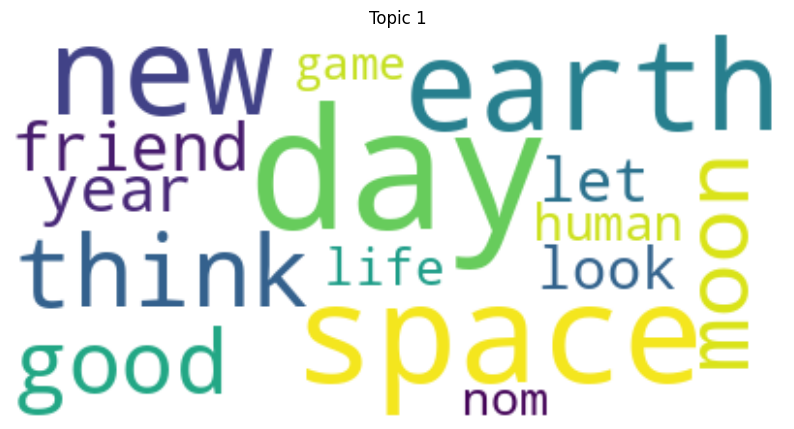

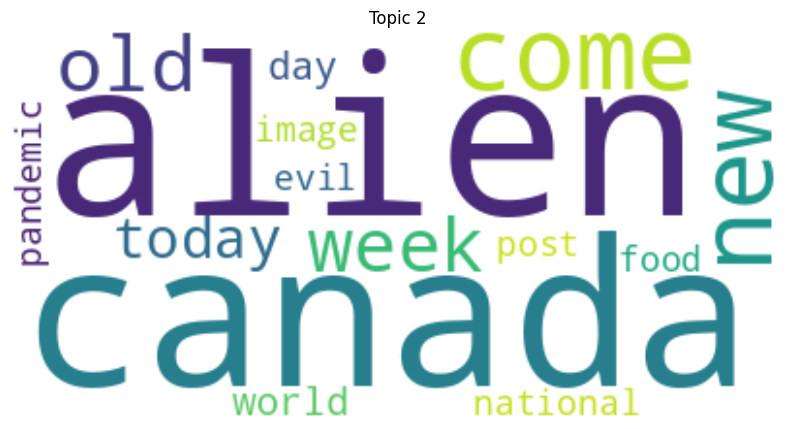

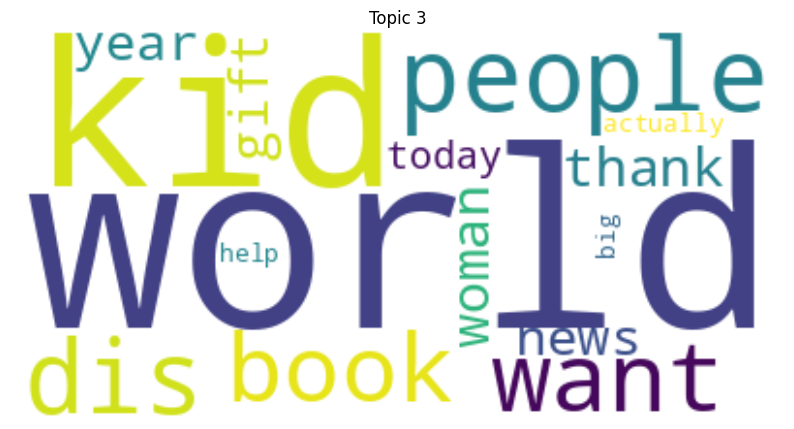

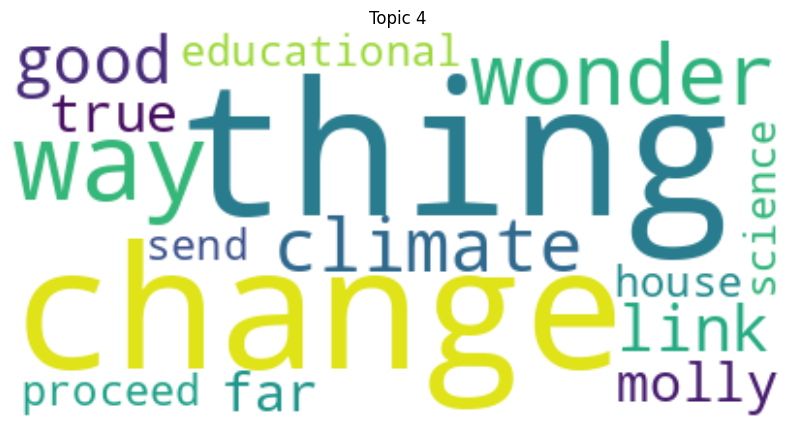

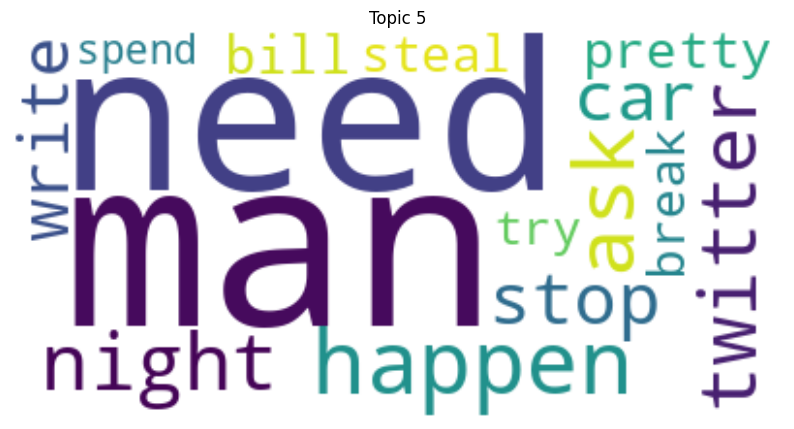

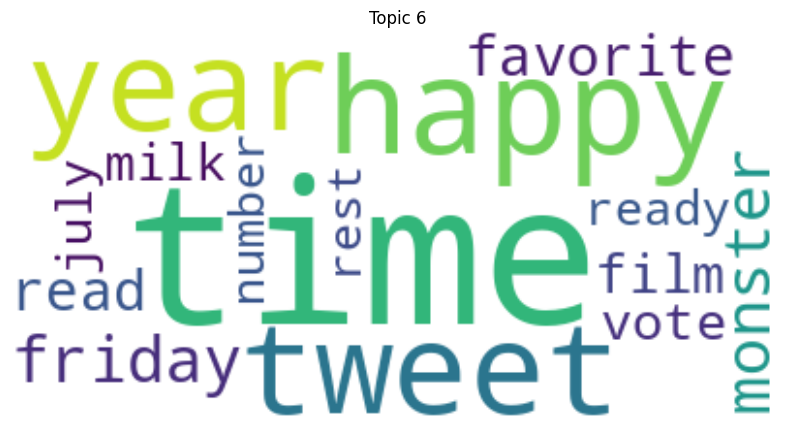

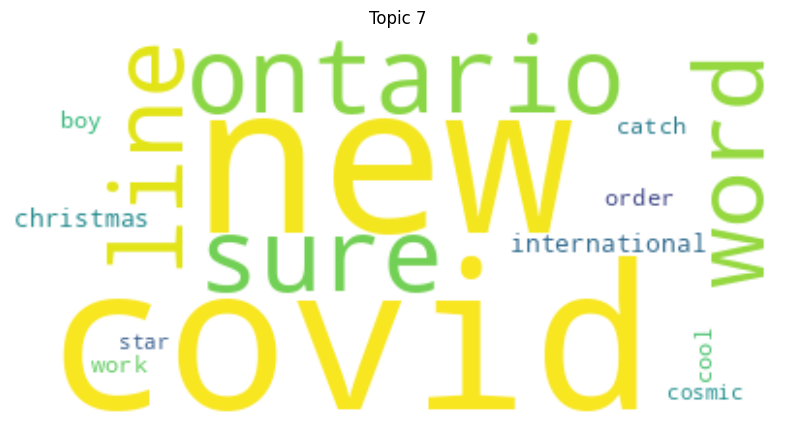

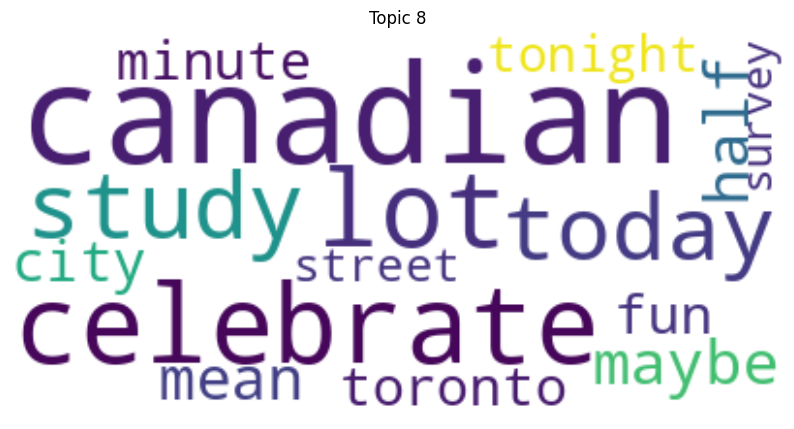

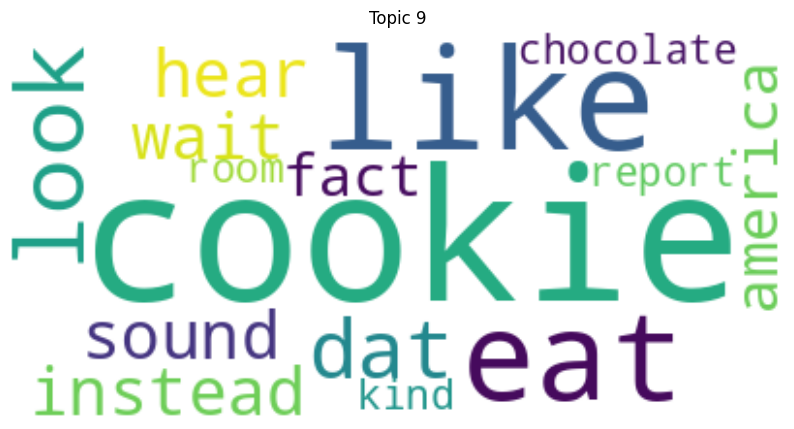

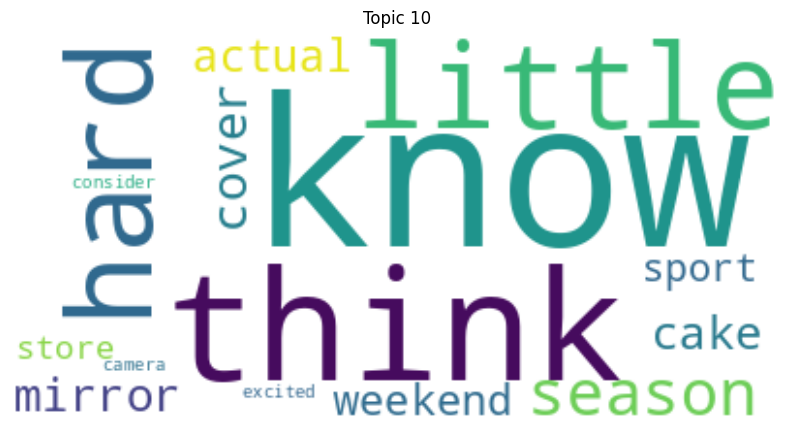

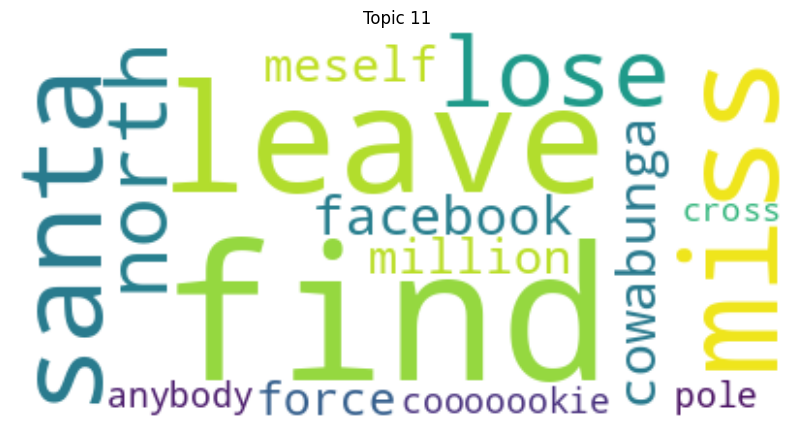

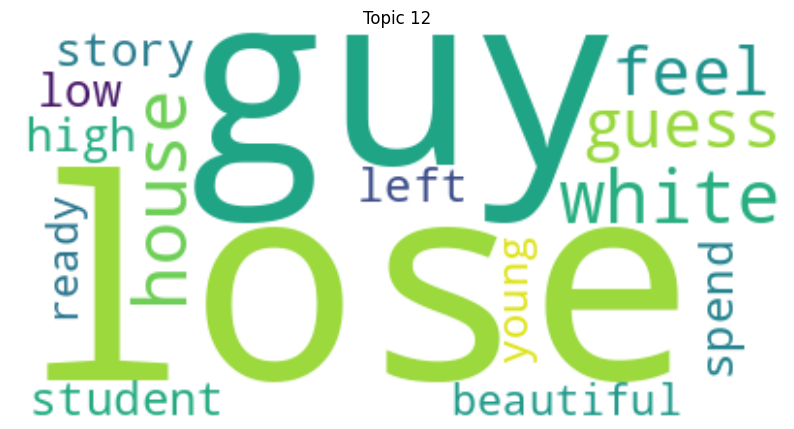

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for topic_num in range(12):
    words = dict(lda_model.show_topic(topic_num, 15))
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(words)

    plt.figure(figsize=(10,20))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_num+1}")
    plt.show()


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


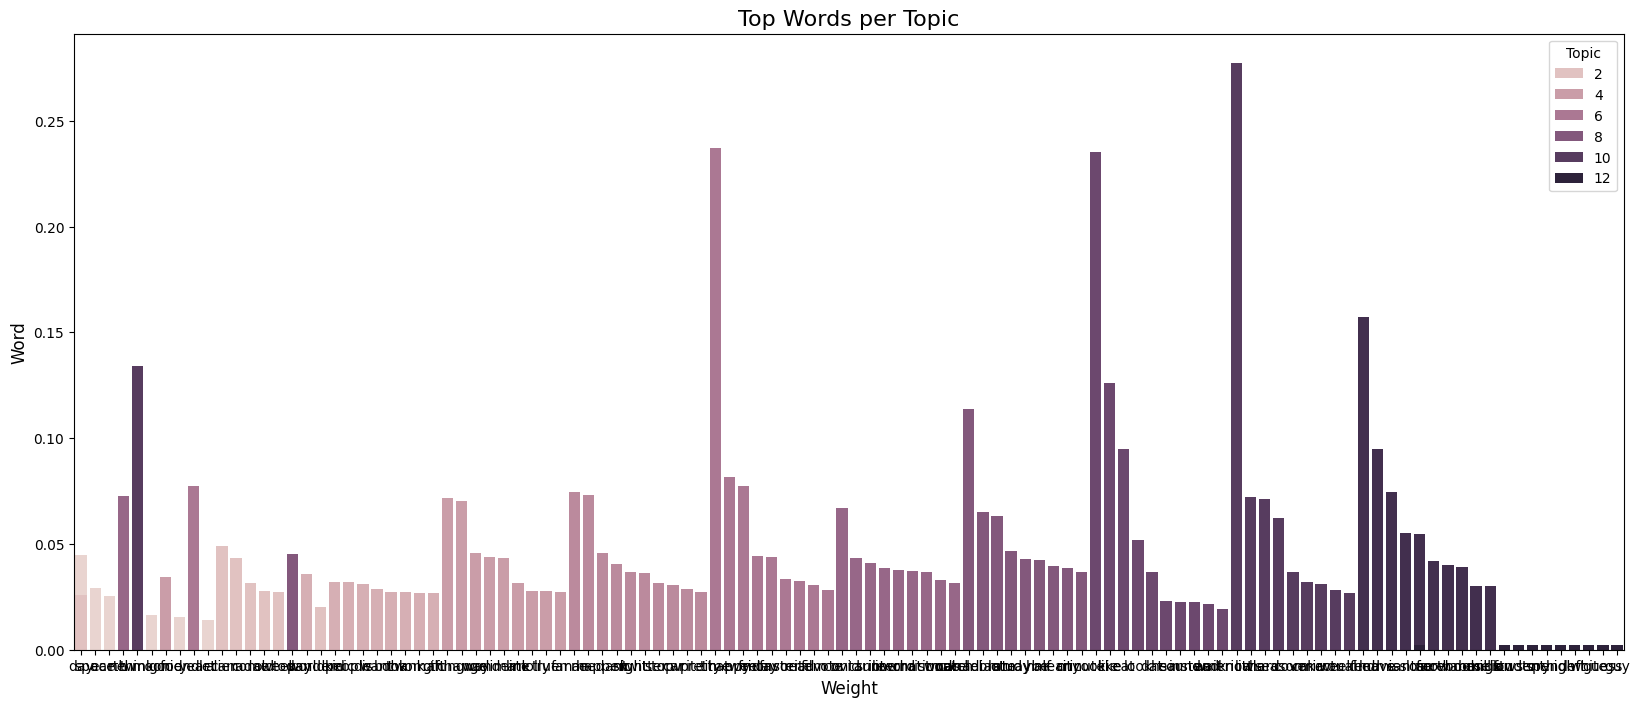

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get top words for each topic
topics = lda_model.show_topics(num_topics=12, num_words=10, formatted=False)

# Convert to DataFrame
data = []
for topic_num, words in topics:
    for word, weight in words:
        data.append([topic_num+1, word, weight])

df = pd.DataFrame(data, columns=["Topic", "Word", "Weight"])

# Plot
plt.figure(figsize=(20, 8))  # Larger figure
sns.barplot(data=df, x="Word", y="Weight", hue="Topic", dodge=False)
plt.title("Top Words per Topic", fontsize=16)
plt.xlabel("Weight", fontsize=12)
plt.ylabel("Word", fontsize=12)
plt.legend(title="Topic", bbox_to_anchor=(1, 1))  # Move legend outside
plt.show()
